<a href="https://colab.research.google.com/github/Predic-learning/Weather-prediction/blob/main/Predic_Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
#data = pd.read_csv('/content/drive/MyDrive/TempPredict/Weather 1_3_2023.csv')
#data = pd.read_csv('/content/drive/MyDrive/TempPredict/dataDayM.csv')
data = pd.read_csv('/content/drive/MyDrive/TempPredict/d123_2Weather15_17.csv')
#data['Tools'].replace({'AIR':0, 'PC':1 , 'lamp':2}, inplace=True)
data.head()

,Timestamp,Temperature,Humidity,Direction,Speed,Rainfall,Pressure,PM 2.5
0,"1/2/2023, 15:30:01",39.44,26,225,3.22,0.0,998.4,62
1,"1/2/2023, 15:30:04",39.44,26,225,3.22,0.0,998.5,59
2,"1/2/2023, 15:30:07",39.44,26,225,3.22,0.0,998.5,57
3,"1/2/2023, 15:30:10",39.44,26,225,3.22,0.0,998.5,57
4,"1/2/2023, 15:30:13",39.44,26,225,3.22,0.0,998.5,57


In [ ]:
X = data[['Humidity',	'Direction', 'Speed',	'Rainfall',	'Pressure',	'PM 2.5']].values
y = data[['Temperature']].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X_train = torch.tensor(X_train).type(torch.float)
X_test = torch.tensor(X_test).type(torch.float)
y_train = torch.tensor(y_train).type(torch.float)
y_test = torch.tensor(y_test).type(torch.float)
X_train.dtype, X_test.dtype, y_train.dtype, y_test.dtype, y_train.shape


(torch.float32,
 torch.float32,
 torch.float32,
 torch.float32,
 torch.Size([6096, 1]))

In [ ]:
import torch.nn.functional as F
class Model(nn.Module):
   #1. model initailization
    def __init__(self, in_features, h1, h2, h3, out_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features, h1)
        self.layer2 = nn.Linear(h1, h2)
        self.layer3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)

# 2. How model works
    def forward(self,x):
       x = F.relu(self.layer1(x))
       x = F.relu(self.layer2(x))
       x = F.relu(self.layer3(x))
       x = self.out(x)
       return x
model = Model(6, 64, 128, 256, 1)
model

Model(
  (layer1): Linear(in_features=6, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
#หาค่าความถูกต้องของข้อมูล
def accuracy_fn(y_predict_class, y_true_class):
  correct = torch.sum(y_predict_class == y_true_class)
  return (correct/len(y_predict_class))*100

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

criterion = RMSELoss()
#criterion = nn.L1Loss()
#criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr = 0.0001)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
# training loop RMSE
Epochs = 3000

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range (Epochs):
  y_pred = model(X_train)

  train_loss = criterion(y_pred, y_train)
  train_losses.append(train_loss.item())

  acc = r2_score(y_pred.detach().numpy(), y_train.detach().numpy())
  train_accuracies.append(acc)

  with torch.no_grad():
    y_test_pred = model(X_test)

    test_loss = criterion(y_test_pred, y_test)
    test_losses.append(test_loss.item())

    test_acc = r2_score(y_test_pred.detach().numpy(), y_test.detach().numpy())
    test_accuracies.append(test_acc)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    if epoch %100 == 0:
      print(f'Epoch: {epoch}, train_loss: {train_loss.item()}, test_loss:{test_loss.item()}, train_acc: {acc*100:.2f}%, test_acc:{test_acc*100:.2f}%')


Epoch: 0, train_loss: 39.955108642578125, test_loss:39.992130279541016, train_acc: -79075495.48%, test_acc:-80477806.47%
Epoch: 100, train_loss: 37.43935775756836, test_loss:37.517242431640625, train_acc: -108864.04%, test_acc:-109820.32%
Epoch: 200, train_loss: 21.492321014404297, test_loss:21.857891082763672, train_acc: -610.11%, test_acc:-622.53%
Epoch: 300, train_loss: 8.739975929260254, test_loss:9.468917846679688, train_acc: -17.76%, test_acc:-17.15%
Epoch: 400, train_loss: 5.187485694885254, test_loss:5.937905311584473, train_acc: 1.17%, test_acc:0.63%
Epoch: 500, train_loss: 4.063854694366455, test_loss:4.676586627960205, train_acc: 10.39%, test_acc:8.87%
Epoch: 600, train_loss: 3.356010675430298, test_loss:3.8903110027313232, train_acc: 16.25%, test_acc:14.14%
Epoch: 700, train_loss: 2.7243399620056152, test_loss:3.210350751876831, train_acc: 23.05%, test_acc:20.11%
Epoch: 800, train_loss: 2.14199161529541, test_loss:2.577932119369507, train_acc: 31.75%, test_acc:27.98%
Epoch:

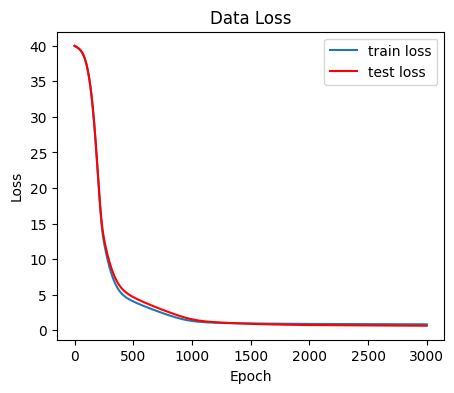

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(range(Epochs), train_losses, label='train loss')
plt.plot(range(Epochs), test_losses, 'r', label='test loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Data Loss")
plt.legend()

Text(0.5, 1.0, 'Accuracy')

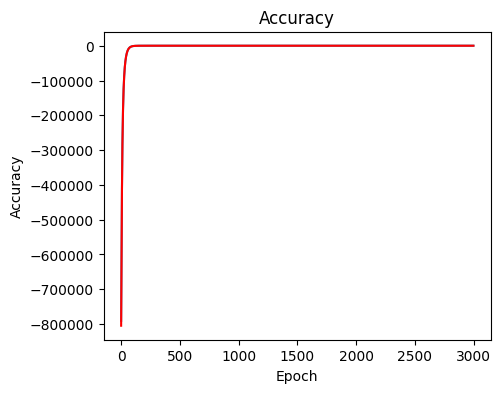

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(range(Epochs), train_accuracies, label='train loss')
plt.plot(range(Epochs), test_accuracies, 'r', label='test loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")